# Model selection and evaluation

__Notes__

1. Create set of rules for what reviews to accept or throw out
    1. Min or max number of words
    1. Include URLs or not
    1. Emojis
    1. Eliminate stop words
    
1. Model selection
    1. CNN for usefulness
    1. Sample from useful reviews only
    1. Setup T5 transfering learning model to generate "justification" text

- LSTM is good
    - You can add in an attention layer because it can look backwards and learn what words were more important than others
- CNN is good for sentence classification 
    - With a fully connected Dense layer it is not good at generalizing
- BERT is good because of its self-attention mechanism where every word looks at every other layer
    - Use the CLS token as the only thing you feed into the output layer that is going to make the prediction on the classification

## 0.0 Notebook setup

### X.X Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
! mkdir data

In [ ]:
! cp "/content/gdrive/My Drive/nlp-book-reviews/data/electronics.csv" ./data/

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
!pip install --quiet transformers

### X.X Local setup

In [300]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [301]:
# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc, accuracy_score

# Model building
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, Flatten, LSTM, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# BERT-specific
# from transformers import BertTokenizer, TFBertForSequenceClassification
# from transformers import InputExample, InputFeatures

In [302]:
# Local
data = '../data/combined.csv'

# Colab
# data = './data/combined.csv'

review_samples = pd.read_csv(data)

In [303]:
# Create sentiment axis label for plots
sentiment = ['Not Useful', 'Useful']

# Check split of useful / not useful
review_samples['useful'].value_counts()

1    2839
0    1616
Name: useful, dtype: int64

## X.X Electronics

In [304]:
electronics = review_samples[review_samples['category'] == 'electronics']

### X.X Naive Bayes - Electronics

In [308]:
reviews = electronics['review_processed'].fillna('no review')
labels = electronics['useful'].astype(int)

In [309]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_dev_tfidf = tf_idf.transform(X_dev)
X_test_tfidf = tf_idf.transform(X_test)

# Use SMOTE to resolve class imbalance
sm = SMOTE(random_state=0)
X_train_tfidf, y_train = sm.fit_resample(X_train_tfidf, y_train)

In [311]:
# Build model
nb_model = MultinomialNB(alpha=1.8)

# Fit model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.8)

In [312]:
# Evaluate model on dev data
train_acc = nb_model.score(X_train_tfidf, y_train)
dev_acc = nb_model.score(X_dev_tfidf, y_dev)
test_acc = nb_model.score(X_test_tfidf, y_test)

print(train_acc, dev_acc, test_acc)

0.9952718676122931 0.5483870967741935 0.592741935483871


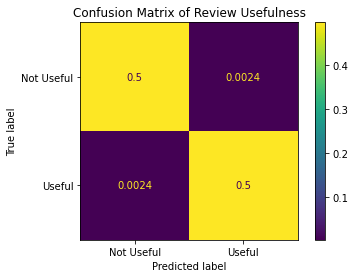

In [313]:
# Evaluate model on test data and plot confusion matrix
y_true = y_train
y_pred = nb_model.predict(X_train_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

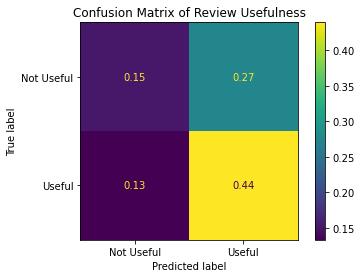

In [314]:
# Evaluate model on test data and plot confusion matrix
y_true = y_test
y_pred = nb_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

AUC: 0.5630


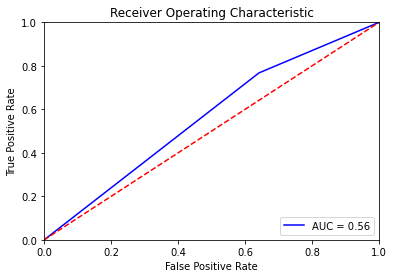

In [315]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## X.X Tokenization and analytics

In [316]:
# Set tokenization parameters
num_words = 4000
num_len = 512
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize review text
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Additional tokenization parameters
max_words = len(tokenizer.word_index)
max_len = max([len(x) for x in sequences])

# Pad review text tokens
review_tokens = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=num_len)

In [317]:
len(tokenizer.word_counts)

6052

In [318]:
vocab = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'frequency'])
vocab.sort_values('frequency', ascending=False).head(10)

,word,frequency
14,sound,656
82,use,629
63,work,561
13,good,513
179,one,455
49,great,438
96,get,411
74,headphone,391
11,speaker,388
2,well,332


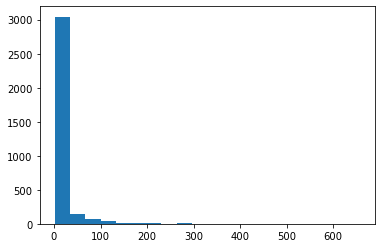

In [319]:
filtered_vocab = vocab[vocab['frequency'] > 1]
plt.hist(filtered_vocab['frequency'], bins=20)
plt.show()

In [320]:
print('Max words in vocabulary: {}'.format(max_words))
print('Max sequence length: {}'.format(max_len))
print('\n')

print('Words allowed in vocabulary: {}'.format(num_words))
print('Allowed sequence length: {}'.format(num_len))
print('\n')

print('Example processed review:')
print(review_samples['review_processed'].iloc[0])
print('\n')

print('Example tokenized review:')
print(review_tokens[0])

Max words in vocabulary: 6053
Max sequence length: 977


Words allowed in vocabulary: 4000
Allowed sequence length: 512


Example processed review:
works pissa


Example tokenized review:
[ 222 3343    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 

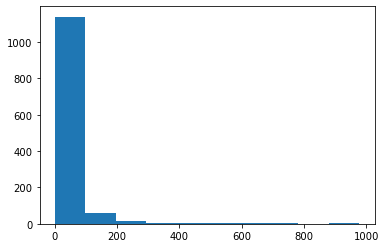

In [321]:
seq_len = [len(x) for x in sequences]
d = {'sequence': sequences, 'length': seq_len}
seqs = pd.DataFrame(data = d)

plt.hist(seqs['length'])
plt.show()

In [322]:
seqs[seqs['length'] > 512]

,sequence,length
21,"[1462, 3361, 162, 207, 104, 451, 6, 3362, 974,...",838
69,"[3461, 79, 291, 1187, 91, 181, 1500, 15, 41, 7...",616
157,"[663, 3662, 602, 3663, 25, 9, 1365, 3, 941, 53...",977
395,"[2835, 1891, 135, 582, 2836, 2837, 582, 217, 2...",951
618,"[55, 335, 23, 47, 16, 18, 279, 393, 21, 937, 5...",749
666,"[257, 1224, 577, 2313, 40, 279, 53, 130, 52, 1...",701
682,"[2835, 1891, 135, 582, 2836, 2837, 582, 217, 2...",951
793,"[280, 3097, 274, 181, 1, 47, 36, 221, 181, 15,...",585
930,"[280, 3097, 1, 1024, 16, 40, 36, 805, 868, 102...",897
1086,"[352, 103, 868, 55, 17, 642, 40, 1454, 9, 168,...",652


### X.X CNN - Electronics

In [323]:
# Set model hyperparamters
output_dim = 256
epochs = 10
batch_size = 512
dropout_rate = 0.0
num_classes = len(np.unique(labels, axis=0))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               epsilon=0.00000001,
                               clipnorm=1.0
                              )
loss_func = 'binary_crossentropy'
metrics = ['accuracy']

In [324]:
# # Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(review_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Use SMOTE to balance the training set
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [325]:
y_test.shape

(248,)

In [326]:
# Build model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_words, output_dim=output_dim, input_length=num_len))
cnn_model.add(Conv1D(16, 3, padding='same', activation='relu'))
# cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
cnn_model.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 512, 256)          1024000   
                                                                 
 conv1d_19 (Conv1D)          (None, 512, 16)           12304     
                                                                 
 flatten_18 (Flatten)        (None, 8192)              0         
                                                                 
 dense_41 (Dense)            (None, 256)               2097408   
                                                                 
 dense_42 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,133,969
Trainable params: 3,133,969
Non-trainable params: 0
_________________________________________________________________


In [327]:
# Fit model
cnn_model.fit(X_train,
              y_train,
              validation_data=(X_dev, y_dev),
              epochs=epochs,
              batch_size=batch_size,
              verbose=2
             )

Epoch 1/10
2/2 - 2s - loss: 0.7174 - accuracy: 0.4941 - val_loss: 0.6928 - val_accuracy: 0.5000 - 2s/epoch - 1s/step
Epoch 2/10
2/2 - 1s - loss: 0.6889 - accuracy: 0.5473 - val_loss: 0.6865 - val_accuracy: 0.5484 - 1s/epoch - 617ms/step
Epoch 3/10
2/2 - 1s - loss: 0.6872 - accuracy: 0.5000 - val_loss: 0.6870 - val_accuracy: 0.5484 - 1s/epoch - 600ms/step
Epoch 4/10
2/2 - 1s - loss: 0.6794 - accuracy: 0.5000 - val_loss: 0.6872 - val_accuracy: 0.5484 - 1s/epoch - 621ms/step
Epoch 5/10
2/2 - 1s - loss: 0.6686 - accuracy: 0.5142 - val_loss: 0.6862 - val_accuracy: 0.5726 - 1s/epoch - 627ms/step
Epoch 6/10
2/2 - 1s - loss: 0.6534 - accuracy: 0.6584 - val_loss: 0.6835 - val_accuracy: 0.5847 - 1s/epoch - 607ms/step
Epoch 7/10
2/2 - 1s - loss: 0.6314 - accuracy: 0.7612 - val_loss: 0.6801 - val_accuracy: 0.5968 - 1s/epoch - 602ms/step
Epoch 8/10
2/2 - 1s - loss: 0.6017 - accuracy: 0.8310 - val_loss: 0.6760 - val_accuracy: 0.5968 - 1s/epoch - 605ms/step
Epoch 9/10
2/2 - 1s - loss: 0.5643 - accura

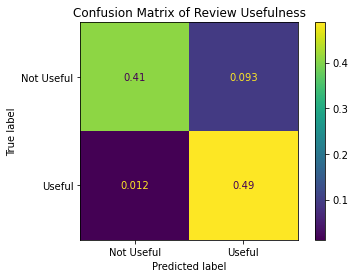

In [328]:
# Plot confusion matrix on training data
y_true = y_train
y_pred = (cnn_model.predict(X_train) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

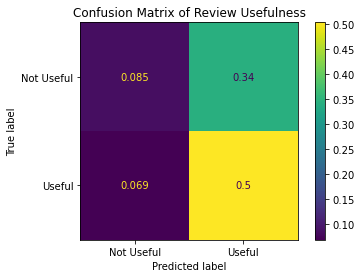

In [329]:
# Plot confusion matrix
y_true = y_test
y_pred = (cnn_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [330]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.20      0.29       106
           1       0.60      0.88      0.71       142

    accuracy                           0.59       248
   macro avg       0.57      0.54      0.50       248
weighted avg       0.58      0.59      0.53       248



In [331]:
# Evaluate model
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

8/8 [==============================] - 0s 12ms/step - loss: 0.6939 - accuracy: 0.5887
Model performance metrics on test data
Accuracy: 0.5887
Loss: 0.6939
Precision: 0.5770
Recall: 0.5887
F1-score: 0.5313


In [332]:
example0 = "Golf tips magazine is one of the most aptly titled magazines available today. \
            It is chock full of heavily-illustrated exercises and other tips for serious golfers to improve their games.\
            \nThere are a number of golf magazines on the newstand today. Most of them rely on a lifestyle format relying \
            more heavily on lifestyle-type stories about today's hot golfers and the courses they play. Most of them include \
            a brief game tip or two but seem aimed at the casual duffer.\nGolf Tips, on the other hand, features almost nothing \
            but heavily illustrated tips on improving one's swing, eliminating mistakes and putting better. It also is heavily \
            loaded with features on the latest equipment technology. Each issue also seems to feature an article on the technical \
            aspects of a selected major golf course. The articles are written with terminology that serious golfers will understand \
            but that may confuse the weekend player. Judging by the amount of advertising in its early issues, this magazine also \
            appears to be financially healthy.\nIf a reader wants to read about the PGA Tour's superstars, this magazine is not for \
            him/her. But if s/he plans to be one of those superstars, Golf Tips is a good match."

example1 = "The information is interesting and fun, the writing is superb, and the writers and editors have a great sense of humor. \
            I just wish it came out more often!"

example2 = "this data science article is the best ever"

example3 = "i really loved how the technician helped me with the issue that i had"

example4 = "useless comment"

examples = [example0, example1, example2, example3, example4]

In [333]:
def test_examples(model, examples, num_len=512):
    for idx, example in enumerate(examples):
        sequence = tokenizer.texts_to_sequences([example])
        test = pad_sequences(sequence, maxlen=num_len)
        prediction = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
        print(idx, ":", prediction)

In [334]:
test_examples(cnn_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X BERT - Electronics

[TF BERT Tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

In [ ]:
reviews = electronics['review_text'].fillna('no review')

X, y = reviews, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss_func,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               validation_data=(X_dev, y_dev),
                               epochs=epochs)

In [ ]:
# Plot confusion matrix
y_true = y_test
y_pred = (classifier_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [ ]:
# Evaluate model
loss, accuracy = classifier_model.evaluate(X_test, y_test)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

## X.X Furniture

In [335]:
furniture = review_samples[review_samples['category'] == 'furniture']

### X.X Naive Bayes - Furniture

In [336]:
reviews = furniture['review_processed'].fillna('no review')
labels = furniture['useful'].astype(int)

In [339]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_dev_tfidf = tf_idf.transform(X_dev)
X_test_tfidf = tf_idf.transform(X_test)

# Use SMOTE to resolve class imbalance
sm = SMOTE(random_state=0)
X_train_tfidf, y_train = sm.fit_resample(X_train_tfidf, y_train)

In [340]:
# Build model
nb_model = MultinomialNB(alpha=1.8)

# Fit model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.8)

In [341]:
# Evaluate model on dev data
train_acc = nb_model.score(X_train_tfidf, y_train)
dev_acc = nb_model.score(X_dev_tfidf, y_dev)
test_acc = nb_model.score(X_test_tfidf, y_test)

print(train_acc, dev_acc, test_acc)

0.9912280701754386 0.6307277628032345 0.6199460916442049


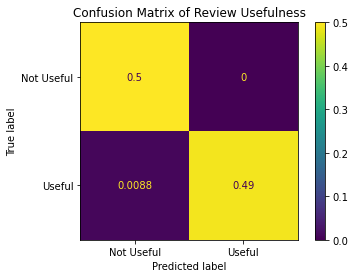

In [342]:
# Evaluate model on test data and plot confusion matrix
y_true = y_train
y_pred = nb_model.predict(X_train_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

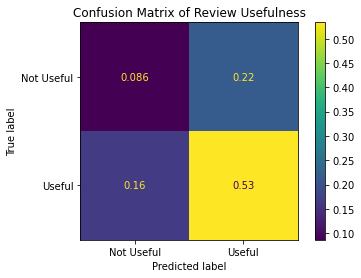

In [343]:
# Evaluate model on test data and plot confusion matrix
y_true = y_test
y_pred = nb_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

AUC: 0.5251


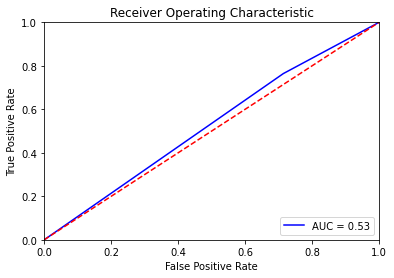

In [344]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## X.X Tokenization and analytics

In [345]:
# Set tokenization parameters
num_words = 4000
num_len = 512
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize review text
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Additional tokenization parameters
max_words = len(tokenizer.word_index)
max_len = max([len(x) for x in sequences])

# Pad review text tokens
review_tokens = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=num_len)

In [346]:
len(tokenizer.word_counts)

5234

In [347]:
vocab = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'frequency'])
vocab.sort_values('frequency', ascending=False).head(10)

,word,frequency
68,look,521
4,one,517
87,mattress,515
669,chair,488
93,get,480
94,bed,466
381,great,445
69,like,443
76,would,439
56,good,394


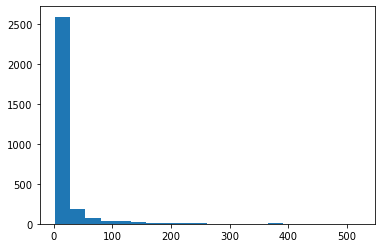

In [348]:
filtered_vocab = vocab[vocab['frequency'] > 1]
plt.hist(filtered_vocab['frequency'], bins=20)
plt.show()

In [349]:
print('Max words in vocabulary: {}'.format(max_words))
print('Max sequence length: {}'.format(max_len))
print('\n')

print('Words allowed in vocabulary: {}'.format(num_words))
print('Allowed sequence length: {}'.format(num_len))
print('\n')

print('Example processed review:')
print(review_samples['review_processed'].iloc[0])
print('\n')

print('Example tokenized review:')
print(review_tokens[0])

Max words in vocabulary: 5235
Max sequence length: 724


Words allowed in vocabulary: 4000
Allowed sequence length: 512


Example processed review:
works pissa


Example tokenized review:
[ 57  46 246  55   3 142  41 850   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 

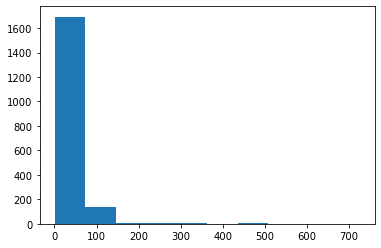

In [350]:
seq_len = [len(x) for x in sequences]
d = {'sequence': sequences, 'length': seq_len}
seqs = pd.DataFrame(data = d)

plt.hist(seqs['length'])
plt.show()

In [351]:
seqs[seqs['length'] > 512]

,sequence,length
282,"[3301, 2406, 910, 1387, 545, 58, 278, 99, 323,...",724


### X.X CNN - Furniture

In [352]:
# Set model hyperparamters
output_dim = 256
epochs = 10
batch_size = 512
dropout_rate = 0.0
num_classes = len(np.unique(labels, axis=0))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               epsilon=0.00000001,
                               clipnorm=1.0
                              )
loss_func = 'binary_crossentropy'
metrics = ['accuracy']

In [353]:
# # Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(review_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Use SMOTE to balance the training set
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [354]:
y_test.shape

(371,)

In [355]:
# Build model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_words, output_dim=output_dim, input_length=num_len))
cnn_model.add(Conv1D(16, 3, padding='same', activation='relu'))
# cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
cnn_model.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 512, 256)          1024000   
                                                                 
 conv1d_20 (Conv1D)          (None, 512, 16)           12304     
                                                                 
 flatten_19 (Flatten)        (None, 8192)              0         
                                                                 
 dense_43 (Dense)            (None, 256)               2097408   
                                                                 
 dense_44 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,133,969
Trainable params: 3,133,969
Non-trainable params: 0
_________________________________________________________________


In [356]:
# Fit model
cnn_model.fit(X_train,
              y_train,
              validation_data=(X_dev, y_dev),
              epochs=epochs,
              batch_size=batch_size,
              verbose=2
             )

Epoch 1/10
4/4 - 3s - loss: 0.7242 - accuracy: 0.4887 - val_loss: 0.6992 - val_accuracy: 0.3127 - 3s/epoch - 848ms/step
Epoch 2/10
4/4 - 2s - loss: 0.6879 - accuracy: 0.6071 - val_loss: 0.6791 - val_accuracy: 0.6253 - 2s/epoch - 597ms/step
Epoch 3/10
4/4 - 2s - loss: 0.6766 - accuracy: 0.6241 - val_loss: 0.6555 - val_accuracy: 0.6819 - 2s/epoch - 588ms/step
Epoch 4/10
4/4 - 2s - loss: 0.6612 - accuracy: 0.6203 - val_loss: 0.6429 - val_accuracy: 0.6523 - 2s/epoch - 605ms/step
Epoch 5/10
4/4 - 2s - loss: 0.6323 - accuracy: 0.6579 - val_loss: 0.6458 - val_accuracy: 0.5930 - 2s/epoch - 555ms/step
Epoch 6/10
4/4 - 2s - loss: 0.5878 - accuracy: 0.7325 - val_loss: 0.6521 - val_accuracy: 0.5687 - 2s/epoch - 552ms/step
Epoch 7/10
4/4 - 2s - loss: 0.5264 - accuracy: 0.8145 - val_loss: 0.6713 - val_accuracy: 0.5391 - 2s/epoch - 562ms/step
Epoch 8/10
4/4 - 2s - loss: 0.4499 - accuracy: 0.8484 - val_loss: 0.6775 - val_accuracy: 0.5553 - 2s/epoch - 592ms/step
Epoch 9/10
4/4 - 2s - loss: 0.3655 - acc

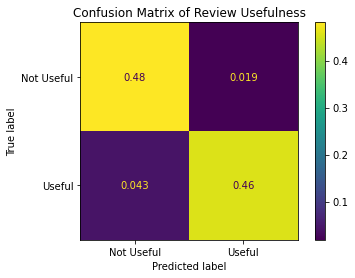

In [357]:
# Plot confusion matrix on training data
y_true = y_train
y_pred = (cnn_model.predict(X_train) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

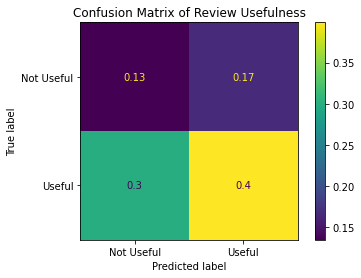

In [358]:
# Plot confusion matrix
y_true = y_test
y_pred = (cnn_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [359]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.45      0.37       112
           1       0.70      0.57      0.63       259

    accuracy                           0.53       371
   macro avg       0.51      0.51      0.50       371
weighted avg       0.59      0.53      0.55       371



In [360]:
# Evaluate model
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

12/12 [==============================] - 0s 11ms/step - loss: 0.7437 - accuracy: 0.5337
Model performance metrics on test data
Accuracy: 0.5337
Loss: 0.7437
Precision: 0.5858
Recall: 0.5337
F1-score: 0.5512


In [362]:
def test_examples(model, examples, num_len=512):
    for idx, example in enumerate(examples):
        sequence = tokenizer.texts_to_sequences([example])
        test = pad_sequences(sequence, maxlen=num_len)
        prediction = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
        print(idx, ":", prediction)

In [363]:
test_examples(cnn_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X BERT - Furniture

In [ ]:
reviews = furniture['review_text'].fillna('no review')

X, y = reviews, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [ ]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
epochs = 5
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss_func,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               validation_data=(X_dev, y_dev),
                               epochs=epochs)

In [ ]:
# Plot confusion matrix
y_true = y_test
y_pred = (classifier_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [ ]:
# Evaluate model
loss, accuracy = classifier_model.evaluate(X_test, y_test)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

## X.X Sports

In [364]:
sports = review_samples[review_samples['category'] == 'sports']

### X.X Naive Bayes - Sports

In [365]:
reviews = sports['review_processed'].fillna('no review')
labels = sports['useful'].astype(int)

In [366]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_dev_tfidf = tf_idf.transform(X_dev)
X_test_tfidf = tf_idf.transform(X_test)

# Use SMOTE to resolve class imbalance
sm = SMOTE(random_state=0)
X_train_tfidf, y_train = sm.fit_resample(X_train_tfidf, y_train)

In [367]:
# Build model
nb_model = MultinomialNB(alpha=1.8)

# Fit model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.8)

In [368]:
# Evaluate model on dev data
train_acc = nb_model.score(X_train_tfidf, y_train)
dev_acc = nb_model.score(X_dev_tfidf, y_dev)
test_acc = nb_model.score(X_test_tfidf, y_test)

print(train_acc, dev_acc, test_acc)

0.989648033126294 0.5384615384615384 0.47985347985347987


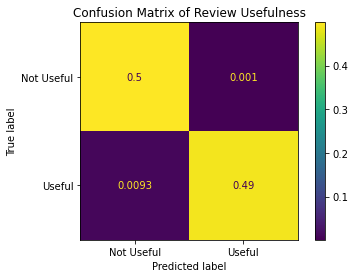

In [369]:
# Evaluate model on test data and plot confusion matrix
y_true = y_train
y_pred = nb_model.predict(X_train_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

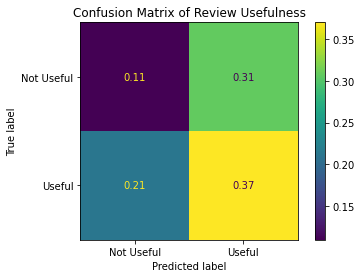

In [370]:
# Evaluate model on test data and plot confusion matrix
y_true = y_test
y_pred = nb_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

AUC: 0.4492


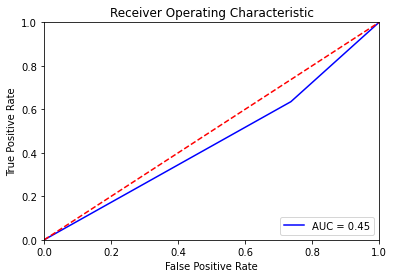

In [371]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## X.X Tokenization and analytics

In [372]:
# Set tokenization parameters
num_words = 4000
num_len = 512
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize review text
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Additional tokenization parameters
max_words = len(tokenizer.word_index)
max_len = max([len(x) for x in sequences])

# Pad review text tokens
review_tokens = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=num_len)

In [373]:
len(tokenizer.word_counts)

5583

In [374]:
vocab = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'frequency'])
vocab.sort_values('frequency', ascending=False).head(10)

,word,frequency
73,use,491
160,great,350
20,get,344
68,good,322
139,one,312
177,like,297
349,work,271
34,well,268
153,would,267
123,make,260


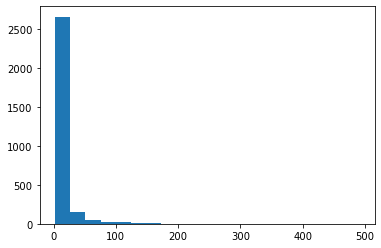

In [375]:
filtered_vocab = vocab[vocab['frequency'] > 1]
plt.hist(filtered_vocab['frequency'], bins=20)
plt.show()

In [376]:
print('Max words in vocabulary: {}'.format(max_words))
print('Max sequence length: {}'.format(max_len))
print('\n')

print('Words allowed in vocabulary: {}'.format(num_words))
print('Allowed sequence length: {}'.format(num_len))
print('\n')

print('Example processed review:')
print(review_samples['review_processed'].iloc[0])
print('\n')

print('Example tokenized review:')
print(review_tokens[0])

Max words in vocabulary: 5584
Max sequence length: 375


Words allowed in vocabulary: 4000
Allowed sequence length: 512


Example processed review:
works pissa


Example tokenized review:
[  73  163 1172  421  172   36  104  163   74  485 2046 2941 2942   33
 1173    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 

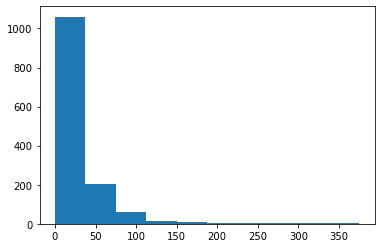

In [377]:
seq_len = [len(x) for x in sequences]
d = {'sequence': sequences, 'length': seq_len}
seqs = pd.DataFrame(data = d)

plt.hist(seqs['length'])
plt.show()

In [378]:
seqs[seqs['length'] > 512]

,sequence,length


### X.X CNN - Sports

In [379]:
# Set model hyperparamters
output_dim = 256
epochs = 10
batch_size = 512
dropout_rate = 0.0
num_classes = len(np.unique(labels, axis=0))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               epsilon=0.00000001,
                               clipnorm=1.0
                              )
loss_func = 'binary_crossentropy'
metrics = ['accuracy']

In [380]:
# # Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(review_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

# Use SMOTE to balance the training set
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [381]:
y_test.shape

(273,)

In [382]:
# Build model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_words, output_dim=output_dim, input_length=num_len))
cnn_model.add(Conv1D(16, 3, padding='same', activation='relu'))
# cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
cnn_model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 512, 256)          1024000   
                                                                 
 conv1d_21 (Conv1D)          (None, 512, 16)           12304     
                                                                 
 flatten_20 (Flatten)        (None, 8192)              0         
                                                                 
 dense_45 (Dense)            (None, 256)               2097408   
                                                                 
 dense_46 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,133,969
Trainable params: 3,133,969
Non-trainable params: 0
_________________________________________________________________


In [383]:
# Fit model
cnn_model.fit(X_train,
              y_train,
              validation_data=(X_dev, y_dev),
              epochs=epochs,
              batch_size=batch_size,
              verbose=2
             )

Epoch 1/10
2/2 - 3s - loss: 0.7108 - accuracy: 0.4896 - val_loss: 0.6570 - val_accuracy: 0.6374 - 3s/epoch - 1s/step
Epoch 2/10
2/2 - 1s - loss: 0.7002 - accuracy: 0.5000 - val_loss: 0.6746 - val_accuracy: 0.6374 - 1s/epoch - 670ms/step
Epoch 3/10
2/2 - 1s - loss: 0.6837 - accuracy: 0.5021 - val_loss: 0.6767 - val_accuracy: 0.6740 - 1s/epoch - 671ms/step
Epoch 4/10
2/2 - 1s - loss: 0.6719 - accuracy: 0.6325 - val_loss: 0.6690 - val_accuracy: 0.6850 - 1s/epoch - 658ms/step
Epoch 5/10
2/2 - 1s - loss: 0.6552 - accuracy: 0.6429 - val_loss: 0.6627 - val_accuracy: 0.6813 - 1s/epoch - 670ms/step
Epoch 6/10
2/2 - 1s - loss: 0.6316 - accuracy: 0.6760 - val_loss: 0.6608 - val_accuracy: 0.6886 - 1s/epoch - 667ms/step
Epoch 7/10
2/2 - 1s - loss: 0.6002 - accuracy: 0.7505 - val_loss: 0.6605 - val_accuracy: 0.6923 - 1s/epoch - 674ms/step
Epoch 8/10
2/2 - 1s - loss: 0.5633 - accuracy: 0.8416 - val_loss: 0.6604 - val_accuracy: 0.6996 - 1s/epoch - 660ms/step
Epoch 9/10
2/2 - 1s - loss: 0.5199 - accura

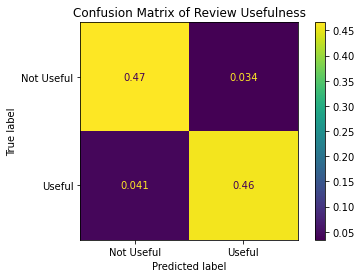

In [384]:
# Plot confusion matrix on training data
y_true = y_train
y_pred = (cnn_model.predict(X_train) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

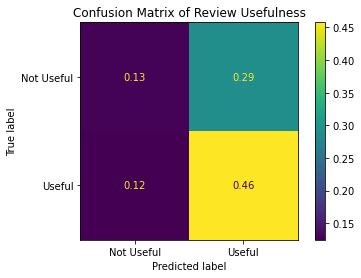

In [385]:
# Plot confusion matrix
y_true = y_test
y_pred = (cnn_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [386]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.31      0.38       114
           1       0.61      0.79      0.69       159

    accuracy                           0.59       273
   macro avg       0.56      0.55      0.54       273
weighted avg       0.57      0.59      0.56       273



In [387]:
# Evaluate model
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

9/9 [==============================] - 0s 11ms/step - loss: 0.7124 - accuracy: 0.5861
Model performance metrics on test data
Accuracy: 0.5861
Loss: 0.7124
Precision: 0.5687
Recall: 0.5861
F1-score: 0.5608


In [388]:
def test_examples(model, examples, num_len=512):
    for idx, example in enumerate(examples):
        sequence = tokenizer.texts_to_sequences([example])
        test = pad_sequences(sequence, maxlen=num_len)
        prediction = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
        print(idx, ":", prediction)

In [389]:
test_examples(cnn_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X BERT - Sports

In [ ]:
reviews = sports['review_text'].fillna('no review')

X, y = reviews, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [ ]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
epochs = 5
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss_func,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               validation_data=(X_dev, y_dev),
                               epochs=epochs)

In [ ]:
# Plot confusion matrix
y_true = y_test
y_pred = (classifier_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [ ]:
# Evaluate model
loss, accuracy = classifier_model.evaluate(X_test, y_test)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))